In [1]:
import numpy as np
from matplotlib import pyplot as plt
import ase.io as aio

import sys
sys.path.insert(0, '/home/sahre/git_repositories/APDFT/prototyping/atomic_energies/')
import utils_qm as uqm

from pyscf import gto

from ase import Atoms

/home/sahre/opt/miniconda3/envs/qm-tools/lib/python3.9/site-packages/pyscf/lib/misc.py:46: H5pyDeprecationWarning: Using default_file_mode other than 'r' is deprecated. Pass the mode to h5py.File() instead.
  h5py.get_config().default_file_mode = 'a'


In [2]:
def parse_line(line, btype = 0):
    line = line.strip('\n')
    values = [float(l) for l in line.split()]
    if btype == 0 or btype == 'rad':
        return(values[1]- values[3])
    if btype == 1 or btype == 'sat':
        return(values[1]- values[-1])
def parse_bind(file, smiles, btype = 0):
    key0 = f'E_{smiles[0]}({smiles[1]})'
    key1 = f'E_{smiles[1]}({smiles[0]})'
    binding_energies = dict()
    with open(file, 'r') as f:
        f.readline() # skip header
        binding_energies[key0] = parse_line(f.readline(), btype)
        binding_energies[key1] = parse_line(f.readline(), btype)
    return(binding_energies)

In [3]:
# read and calculate binding energy data
smiles_list = ['CC','CN','CO','CF','NN','NO','NF','OO', 'OF', 'FF']
binding_energies = dict()
for smiles in smiles_list:
    file = f'/data/sahre/projects/atomic-energies/data/bonding_trends/diatomics/{smiles}/binding_energy.txt'
    binding_energies.update(parse_bind(file, smiles, 'sat'))
    
# generate binding pairs
elements = ['C', 'N', 'O', 'F']
key_pairs = []
for i in range(len(elements)):
    for j in range(i, len(elements)):
        key_pairs.append([f'E_{elements[i]}({elements[j]})', f'E_{elements[j]}({elements[i]})'])

# calculate sum of binding energies
y_vec = []
for kp in key_pairs:
    y_vec.append(binding_energies[kp[0]]+binding_energies[kp[1]])

In [4]:
binding_energies

{'E_C(C)': -4.326712071703781,
 'E_C(N)': -4.594258873734599,
 'E_N(C)': -5.340208895567731,
 'E_C(O)': -4.8166024151985845,
 'E_O(C)': -6.299490810645267,
 'E_C(F)': -4.988687810322606,
 'E_F(C)': -7.2589384669378845,
 'E_N(N)': -5.674806989466795,
 'E_N(O)': -5.916951443340125,
 'E_O(N)': -6.70403028174929,
 'E_N(F)': -6.17889724694496,
 'E_F(N)': -7.823486858291226,
 'E_O(O)': -7.09473087012535,
 'E_O(F)': -7.256926987327951,
 'E_F(O)': -8.134868399613097,
 'E_F(F)': -8.373234897735806}

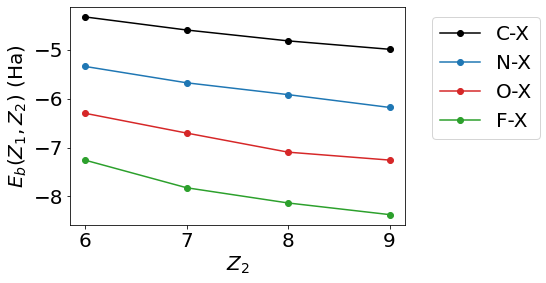

In [5]:
z = [6, 7, 8, 9]
plt.rcParams['font.size'] = 20
plt.rcParams['figure.figsize'] = [6,4]

plt.plot(z, [binding_energies['E_C(C)'], binding_energies['E_C(N)'], binding_energies['E_C(O)'], binding_energies['E_C(F)']], '-o', color='black', label = 'C-X')
plt.plot(z, [binding_energies['E_N(C)'], binding_energies['E_N(N)'], binding_energies['E_N(O)'], binding_energies['E_N(F)']], '-o', color='tab:blue', label = 'N-X')
plt.plot(z, [binding_energies['E_O(C)'], binding_energies['E_O(N)'], binding_energies['E_O(O)'], binding_energies['E_O(F)']], '-o', color='tab:red', label = 'O-X')
plt.plot(z, [binding_energies['E_F(C)'], binding_energies['E_F(N)'], binding_energies['E_F(O)'], binding_energies['E_F(F)']], '-o', color='tab:green', label = 'F-X')

plt.xlabel('$Z_2$')
plt.ylabel('$E_b(Z_1, Z_2)$ (Ha)')
plt.legend(bbox_to_anchor = (1.05, 1))

In [6]:
coeff_mat = np.array([[2,0,0,0,12,0,0,0],[1,1,0,0,7,6,0,0],[1,0,1,0,8,0,6,0],[1,0,0,1,9,0,0,6],
[0,2,0,0,0,14,0,0],[0,1,1,0,0,8,7,0],[0,1,0,1,0,9,0,7],
 [0,0,2,0,0,0,16,0], [0,0,1,1,0,0,9,8],[0,0,0,2,0,0,0,18]])

In [7]:
coeffs, mae, rank, sg = np.linalg.lstsq(coeff_mat, y_vec, rcond=None)

In [8]:
mae = np.abs(coeffs@coeff_mat.T-y_vec).mean()

In [9]:
mae

0.030132240049166904

In [10]:
rows = coeff_mat[[0,1,2,4,5,7]]
r1 = rows[:,0:3]
r2 = rows[:,4:-1]
no_ox = np.concatenate((r1, r2),axis=1)
fit2 = np.linalg.lstsq(no_ox, np.array(y_vec)[[0,1,2,4,5,7]], rcond=None)

np.abs(fit2[0]@no_ox-np.array(y_vec)[[0,1,2,4,5,7]]).mean()

7.430499384768496

In [11]:
y_vec

[-8.653424143407562,
 -9.93446776930233,
 -11.116093225843851,
 -12.24762627726049,
 -11.34961397893359,
 -12.620981725089415,
 -14.002384105236185,
 -14.1894617402507,
 -15.391795386941048,
 -16.74646979547161]

In [12]:
Z = np.array([6,7,8,9])
E_C_fit = np.array([coeffs[0]+coeffs[4]*z for z in Z])
E_N_fit = np.array([coeffs[1]+coeffs[5]*z for z in Z])
E_O_fit = np.array([coeffs[2]+coeffs[6]*z for z in Z])
E_F_fit = np.array([coeffs[3]+coeffs[7]*z for z in Z])

E_C = []
E_N = []
E_O = []
E_F = []

for k in binding_energies.keys():
    if 'E_C' in k:
        E_C.append(binding_energies[k])
    elif 'E_N' in k:
        E_N.append(binding_energies[k])
    elif 'E_O' in k:
        E_O.append(binding_energies[k])
    elif 'E_F' in k:
        E_F.append(binding_energies[k])

E_C = np.array(E_C)
E_N = np.array(E_N)
E_O = np.array(E_O)
E_F = np.array(E_F)
mae_atomic = []
for e,f in zip([E_C, E_N, E_O, E_F], [E_C_fit, E_N_fit, E_O_fit, E_F_fit]):
    mae_atomic.append(np.abs(e-f).mean())

In [13]:
mae_atomic

[0.7470369329363031,
 0.5605145031479861,
 0.5556946161128562,
 0.8430245166593375]

In [14]:
from scipy.stats import linregress

In [15]:
atomic_binding_energies = dict()
for e, h1 in zip([E_C, E_N, E_O, E_F], elements):
    fit = linregress(Z, e)
    tmp = fit[0]*Z+fit[1]
    print(np.abs(tmp-e).mean())
    for h2, aetmp in zip(elements, tmp):
        key = f'E_{h1}({h2})'
        atomic_binding_energies[key] = aetmp
        
# calculate sum of binding energies
y_vec_indv = []
for kp in key_pairs:
    y_vec_indv.append(atomic_binding_energies[kp[0]]+atomic_binding_energies[kp[1]])

0.023865351726699124
0.018163072573557537
0.06058583847535548
0.08154547330765793


In [16]:
np.abs(np.array(y_vec_indv)-np.array(y_vec)).mean()

0.0730968974872674

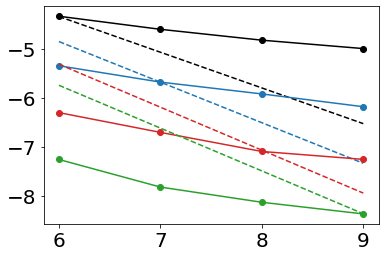

In [17]:
plt.plot(Z, E_C, '-o', color = 'black')
plt.plot(Z, E_C_fit, '--', color = 'black')

plt.plot(Z, E_N, '-o', color = 'tab:blue')
plt.plot(Z, E_N_fit, '--', color = 'tab:blue')

plt.plot(Z, E_O, '-o', color = 'tab:red')
plt.plot(Z, E_O_fit, '--', color = 'tab:red')
         
plt.plot(Z, E_F, '-o', color = 'tab:green')
plt.plot(Z, E_F_fit, '--', color = 'tab:green')

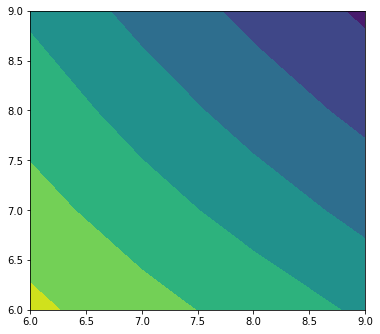

In [20]:
dummy_mat= np.zeros((4,4))
r,c = np.triu_indices(4)

for i,j, val in zip(r, c, y_vec):
    dummy_mat[i,j] = val
    dummy_mat[j,i] = val
    
plt.rcParams['figure.figsize'] = [6,5.5]
plt.contourf(Z,Z, dummy_mat)

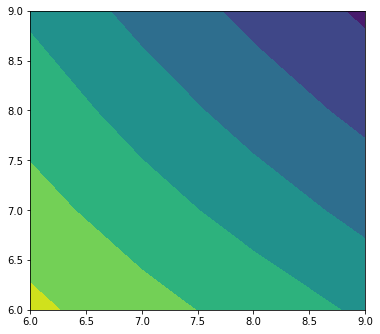

In [21]:
plt.rcParams['figure.figsize'] = [6,5.5]
plt.contourf(Z,Z, dummy_mat)

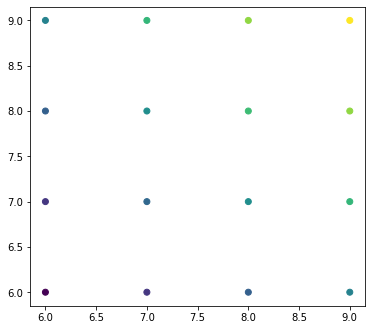

In [22]:
plt.rcParams['figure.figsize'] = [6,5.5]
# plt.contour(Z,Z, e_bind, linestyles='dashdot')
xx, yy = np.meshgrid(Z,Z)
plt.scatter(xx,yy, c= dummy_mat/np.amin(dummy_mat))

# experimental data

In [53]:
import numpy as np
from matplotlib import pyplot as plt
import ase.io as aio

import sys
sys.path.insert(0, '/home/sahre/git_repositories/APDFT/prototyping/atomic_energies/')
import utils_qm as uqm

from pyscf import gto

from ase import Atoms
from ase.units import Bohr

In [54]:
def get_nuc_rep(xyz, spin):
    atoms = aio.read(xyz)
    
    nuc = atoms.get_atomic_numbers()[np.where(atoms.get_atomic_numbers() > 1)]
    pos = atoms.get_positions()[np.where(atoms.get_atomic_numbers() > 1)]
    atoms_heavy = Atoms(numbers=nuc, positions=pos)
#     print(atoms_heavy.get_distance(0,1))
    if nuc.sum()%2:
        spin = 1
    else:
        spin = 0
    
#     print(atoms.get_distance(0,1))
#     print(np.linalg.norm(pos[0]-pos[1]))

#     print(np.linalg.norm(pos[0]-pos[1])/Bohr)
    atoms_pyscf = uqm.ase2pyscf(atoms_heavy)
    mol = gto.Mole()
    mol.atom = atoms_pyscf
    mol.spin = spin
    mol.build()
    return(mol.energy_nuc())

In [55]:
# nuc_frag = dict()
# for s in ['CC', 'NN', 'OO', 'FF']:
#     nuc_frag[s[0]] = get_nuc_rep(f'/data/sahre/projects/atomic-energies/data/bonding_trends/radical_frags/{s}/{s[0]}_opt.xyz', 1)

nuc_diatomics = dict()
# nuc_diatomics_opt = dict()

for s in ['CC','CN','CO','CF','NN','NO','NF','OO', 'OF', 'FF']:
#     nuc_diatomics_opt[s] = get_nuc_rep(f'/data/sahre/projects/atomic-energies/data/bonding_trends/diatomics/{s}/{s}_opt.xyz', 0)
    nuc_diatomics[s] = get_nuc_rep(f'/data/sahre/projects/atomic-energies/data/bonding_trends/diatomics/{s}/{s}.xyz', 0)
    
binding_nuc = dict()
for k in nuc_diatomics.keys():
    binding_nuc[k] = nuc_diatomics[k]*2600#-nuc_frag[k[0]]-nuc_frag[k[1]]
    
# binding_nuc_opt = dict()
# for k in nuc_diatomics_opt.keys():
#     binding_nuc_opt[k] = nuc_diatomics_opt[k]-nuc_frag[k[0]]-nuc_frag[k[1]]
binding_nuc

{'CC': 34852.72406080705,
 'CN': 40661.511263745575,
 'CO': 46470.2986271903,
 'CF': 52279.08613988504,
 'NN': 47438.42997446622,
 'NO': 54215.34834279035,
 'NF': 60992.26694514232,
 'OO': 61960.39816936382,
 'OF': 69705.44763318235,
 'FF': 78418.62882824495}

get bond formation energy BFE in Ha

$\text{BFE} = - \text{BDE}$

In [56]:
ref_bde = np.array([359.2, 337.7, 370.2, 452, 259.6, 253.5, 283.6, 195.2, 194.9, 151.7])
bfe = -ref_bde#*0.000381
bfe

array([-359.2, -337.7, -370.2, -452. , -259.6, -253.5, -283.6, -195.2,
       -194.9, -151.7])

calculate electronic part of binding energy

$\text{EBDE} = \text{BDE} - E_\text{nuc, XY}$

In [57]:
nbde = np.array(list(binding_nuc.values()))

ebde_exp = bfe-nbde # electronic binding energy
# y_vec_exp_opt = binding_tot-np.array(list(binding_nuc_opt.values()))

In [58]:
nbde

array([34852.72406081, 40661.51126375, 46470.29862719, 52279.08613989,
       47438.42997447, 54215.34834279, 60992.26694514, 61960.39816936,
       69705.44763318, 78418.62882824])

In [59]:
ebde_exp/2600

array([-13.54304772, -15.76892741, -18.0155764 , -20.28118698,
       -18.34539614, -20.94955705, -23.56764113, -23.9059993 ,
       -26.88474909, -30.21935724])

get coefficients for system of coupled linear equations from EBDE

$ \text{EBDE}(Z, Z') = a_Z + b_Z \cdot Z' + a_{Z'} + b_{Z'} \cdot Z$

In [60]:
coeff_mat = np.array([[2,0,0,0,12,0,0,0],[1,1,0,0,7,6,0,0],[1,0,1,0,8,0,6,0],[1,0,0,1,9,0,0,6],
[0,2,0,0,0,14,0,0],[0,1,1,0,0,8,7,0],[0,1,0,1,0,9,0,7],
 [0,0,2,0,0,0,16,0], [0,0,1,1,0,0,9,8],[0,0,0,2,0,0,0,18]])

coeffs, maen, rank, sg = np.linalg.lstsq(coeff_mat, ebde_exp, rcond=None)

calculate mae and r2 of the fit

In [61]:
mae = np.abs(coeffs@coeff_mat.T-ebde_exp).mean()

var_ue = ((coeffs@coeff_mat.T-ebde_exp)**2).sum()
var_tot = ((ebde_exp - ebde_exp.mean())**2).sum()
r2 = 1 - var_ue/var_tot

print(f'MAE of EBDE in (Ha) = {mae} in kJ/mol {mae*2600}')
print(f'r2 of EBDE in (Ha) = {r2}')

MAE of EBDE in (Ha) = 1.368188529071631 in kJ/mol 3557.2901755862404
r2 of EBDE in (Ha) = 0.9999999816086077


calculate BDE from fit

$ \text{EBDE}(Z, Z') = a_Z + b_Z \cdot Z' + a_{Z'} + b_{Z'} \cdot Z$

$BDE = EBDE + NBDE$

Example NF (BDE = 283.6 kJ/mol)

In [62]:
-(coeffs[1]+coeffs[5]*9+coeffs[3]+coeffs[7]*7+23.458564209670122*2600)

284.945907633497

In [65]:
coeffs

array([ -214.77011942,  -354.87348733,  -517.56269922,  -716.37119726,
       -2898.5471655 , -3356.43467261, -3820.15907104, -4285.43658782])

In [63]:
ebde_el = coeffs@coeff_mat.T
predicted_bde = -(ebde_el + nbde)

mae_final = np.abs(predicted_bde-ref_bde).mean()
r2_final = 1 - ((predicted_bde-ref_bde)**2).sum()/((ref_bde-ref_bde.mean())**2).sum()

print(f'MAE of BDE in in kJ/mol {mae_final}')
print(f'r2 of BDE in (Ha) = {r2_final}')

MAE of BDE in in kJ/mol 1.3681885290710483
r2 of BDE in (Ha) = 0.9996319920157827


NameError: name 'ntmp' is not defined

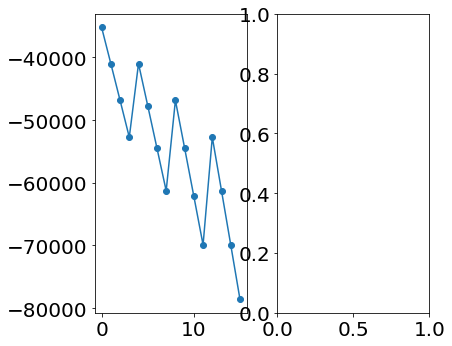

In [64]:
fig, ax = plt.subplots(1,2)
ax[0].plot(np.array([-13.54181847, -15.76727617, -18.0146822 , -20.27940012, -15.76727617, -18.34514431, -20.94718465, -23.5671286, -18.0146822, -20.94718465, -23.90608314,
       -26.88347699, -20.27940012, -23.5671286, -26.88347699, -30.21891248])*2600,'-o')
ax[1].plot(np.array(ntmp)*2600, '-o')
fig.tight_layout()

In [ ]:
ntmp = []
for s in z:
    ntmp.extend(s*z)

In [33]:
ntmp

NameError: name 'ntmp' is not defined

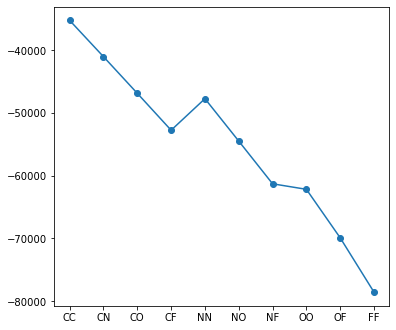

In [34]:
plt.plot(['CC','CN','CO','CF','NN','NO','NF','OO', 'OF', 'FF'],ebde_el, '-o')

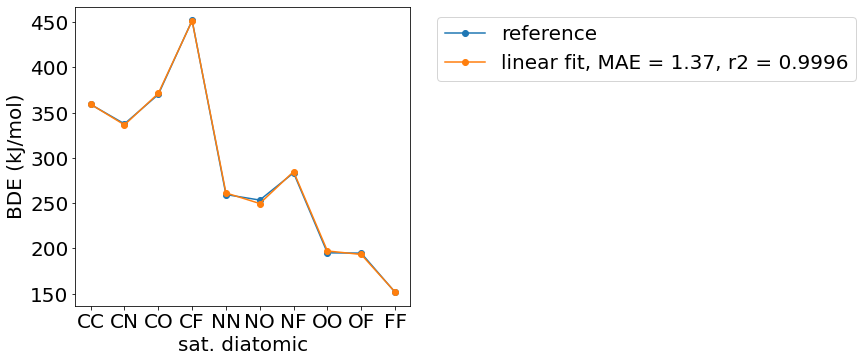

In [66]:
plt.rcParams['font.size'] = 20
plt.plot(['CC','CN','CO','CF','NN','NO','NF','OO', 'OF', 'FF'], ref_bde, '-o',label = 'reference')
plt.plot(['CC','CN','CO','CF','NN','NO','NF','OO', 'OF', 'FF'], predicted_bde, '-o',label = f'linear fit, MAE = {np.round(mae_final, 2)}, r2 = {np.round(r2_final, 4)}')
# plt.plot(['CC','CN','CO','CF','NN','NO','NF','OO', 'OF', 'FF'], predicted_bde_opt, '-o',label = f'linear fit opt, MAE = {np.round(mae_opt, 2)*2600}, r2 = {np.round(r2_opt,4)}')

plt.ylabel('BDE (kJ/mol)')
plt.xlabel('sat. diatomic')
plt.legend(bbox_to_anchor = (1.05,1))

In [36]:
predicted_bde

array([359.38216401, 336.57053713, 371.36594165, 451.59919319,
       261.40241668, 249.67872187, 284.94590763, 197.27236566,
       193.41060517, 151.972147  ])

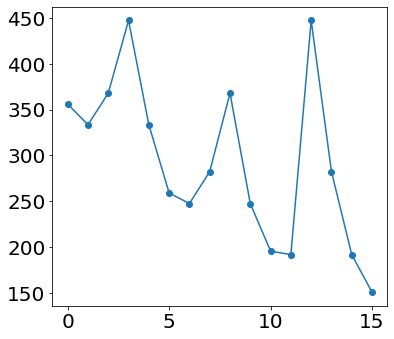

In [37]:
plt.plot([356.00397128, 333.40677498, 367.87510236, 447.3541601, 333.40677498,258.94523318, 247.33174231, 282.26741634,367.87510236,247.33174231, 195.41800416,
       191.59254702,447.3541601,282.26741634,191.59254702, 150.54360827], '-o')

Text(0, 0.5, 'BDE fit (kJ/mol)')

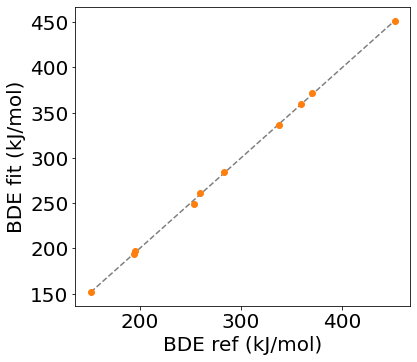

In [38]:
ref_bde_sorted = np.sort(ref_bde)
plt.plot(ref_bde_sorted, ref_bde_sorted, '--', color = 'tab:grey')
plt.plot(ref_bde, predicted_bde, 'o', color = 'tab:orange')
# plt.plot(ref_bde, predicted_bde_opt, 'o', color = 'tab:green')
plt.xlabel('BDE ref (kJ/mol)')
plt.ylabel('BDE fit (kJ/mol)')

Text(0.5, 1.0, 'EBDE')

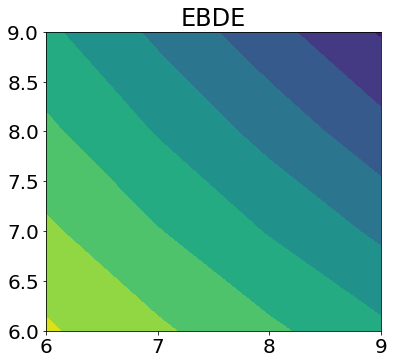

In [39]:
z = np.array([6,7,8,9])
dummy_mat= np.zeros((4,4))
r,c = np.triu_indices(4)

for i,j, val in zip(r, c, ebde_el):
    dummy_mat[i,j] = val
    dummy_mat[j,i] = val
    
plt.rcParams['figure.figsize'] = [6,5.5]
plt.contourf(z,z, dummy_mat)
plt.title("EBDE")

Text(0.5, 1.0, 'BDE ref')

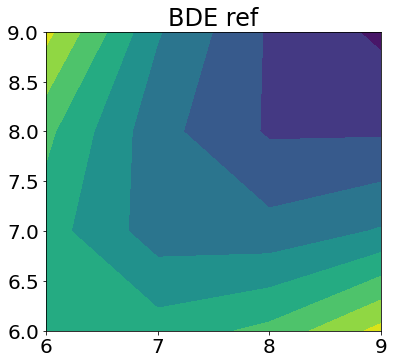

In [40]:
z = np.array([6,7,8,9])
dummy_mat= np.zeros((4,4))
r,c = np.triu_indices(4)

for i,j, val in zip(r, c, ref_bde):
    dummy_mat[i,j] = val
    dummy_mat[j,i] = val
    
plt.rcParams['figure.figsize'] = [6,5.5]
plt.contourf(z,z, dummy_mat)
plt.title("BDE ref")

In [41]:
from scipy.stats import linregress

In [42]:
a_fit = linregress(z, coeffs[:4])
b_fit = linregress(z, coeffs[4:])
a_z = lambda Z: a_fit[0]*Z + a_fit[1]
b_z = lambda Z: b_fit[0]*Z + b_fit[1]

In [43]:
a_fit

LinregressResult(slope=-166.74924453890745, intercept=799.7249582330054, rvalue=-0.9968831064393765, pvalue=0.0031168935606235002, stderr=9.331295616476266, intercept_stderr=70.75805239136376)

In [44]:
b_fit

LinregressResult(slope=-462.43926653926155, intercept=-121.84987519518018, rvalue=-0.999993186606384, pvalue=6.813393615967565e-06, stderr=1.2070872498138208, intercept_stderr=9.153192265440941)

In [45]:
a_z(5)

-34.021264461531814

In [46]:
np.abs(a_z(z)-coeffs[:4]).mean()

14.676282533117664

In [47]:
np.abs(b_z(z)-coeffs[4:]).mean()

1.8475024183668438

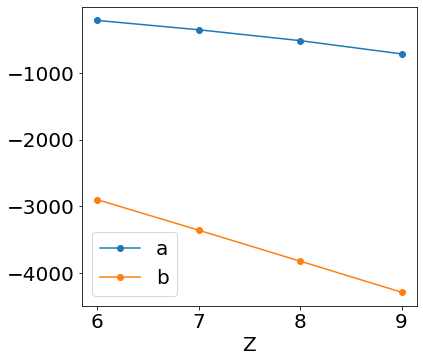

In [48]:
z = np.array([6,7,8,9])
plt.plot(z, coeffs[:4], '-o', label = 'a')
plt.plot(z, coeffs[4:], '-o', label = 'b')
# plt.plot(z, )
plt.xlabel('Z')
plt.legend()

In [49]:
b_z(np.arange(10))

array([ -121.8498752 ,  -584.28914173, -1046.72840827, -1509.16767481,
       -1971.60694135, -2434.04620789, -2896.48547443, -3358.92474097,
       -3821.36400751, -4283.80327405])

In [50]:
(-1.1146226+-1.4692569)/2

-1.29193975

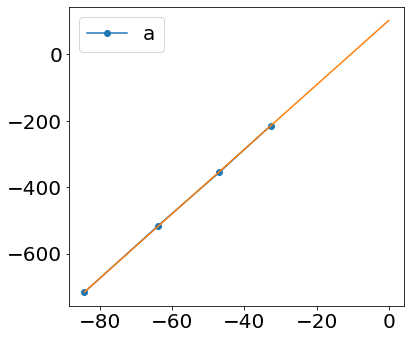

In [51]:
z = np.array([6,7,8,9])
# plt.plot(z, coeffs[:4], '-o', label = 'a')
plt.plot(-0.5*z**(7/3), coeffs[:4], '-o', label = 'a')

z73f = linregress(-0.5*z**(7/3), coeffs[:4])
np.abs(z73f[0]*(-0.5*z**(7/3))+z73f[1]-coeffs[:4]).mean()

plt.plot(-0.5*np.arange(10)**(7/3), -0.5*np.arange(10)**(7/3)*z73f[0]+z73f[1])
# plt.plot(np.arange(5, 10), a_z(np.arange(5, 10)))
# plt.plot(z*z, coeffs[4:], '-o', label = 'b')
# plt.plot(z, )
# plt.ylim([-0.3,-0.005])
# plt.xlim([0,15])
plt.legend()

In [52]:
a_z2 = lambda z: -0.5*z73f[0]*z**(7/3) + z73f[1]
(2*(a_z2(6)+(b_fit[0]*6+b_fit[1])*6) + nbde) #+ a_z2(6)+b_fit[0]*6*6

array([ -336.06667776,  5472.72052518, 11281.50788862, 17090.29540132,
       12249.6392359 , 19026.55760422, 25803.47620657, 26771.60743079,
       34516.65689461, 43229.83808968])

In [160]:
ref_bde

array([359.2, 337.7, 370.2, 452. , 259.6, 253.5, 283.6, 195.2, 194.9,
       151.7])

In [161]:
nbde

array([34852.72406081, 40661.51126375, 46470.29862719, 52279.08613989,
       47438.42997447, 54215.34834279, 60992.26694514, 61960.39816936,
       69705.44763318, 78418.62882824])

In [162]:
b_bor = b_z(5)
a_bor = a_z(5)
d = 1.421151094407886/Bohr

bor_contr = a_bor + b_bor*z
x_contr = np.array([coeffs[0] + coeffs[4]*5, coeffs[1] + coeffs[5]*5, coeffs[2] + coeffs[6]*5, coeffs[3] + coeffs[7]*5])
ebde = bor_contr + x_contr
nbde = nuc_rep_bor = (5*z)/d
bor_bde_fit = -(ebde + nbde)*2600

In [163]:
bor_bde_ref = np.array([426.8, 583.3, 626, 705])

In [164]:
bor_bde_ref_s = np.sort(bor_bde_ref)

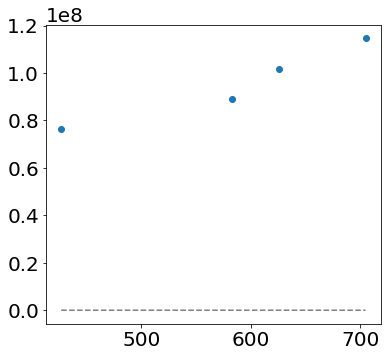

In [165]:
plt.plot(bor_bde_ref_s, bor_bde_ref_s, '--', color = 'tab:grey')
plt.plot(bor_bde_ref, bor_bde_fit, 'o')

In [ ]:
# mae, r2, predicted_bde = fit(coeff_mat, y_vec_exp, binding_nuc)
# mae_opt, r2_opt, predicted_bde_opt = fit(coeff_mat, y_vec_exp_opt, binding_nuc_opt)

In [ ]:
# print(mae, r2)

# print(mae_opt, r2_opt)

- use bond dissociation energy (BDE) for homolytic bond dissociation from https://doi.org/10.1021/jp050857o
- subtract contribution of nuclear repulsion  -> electronic bond dissociation energy (EBDE)
- fit EBDE to model of coupled linear equations
- predict EBDE from linear model (training error = 26 mHa)
- add nuclear repulsion to EBDE -> predicted BDE (in Figure called linear fit)